In [238]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import copy
from re import sub
from decimal import Decimal
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import geopandas
import pycountry
from dataprep.clean import clean_country

pd.set_option('display.max_columns', None)


In [239]:
def curr_to_dec(money):
    return float(sub(r'[^\d.]', '', money))
def gdp_preproc(gdp_df):
    gdp_df = gdp_df[['GDP (nominal, 2017)','GDP per capita','Country']]
    gdp_df['GDP (nominal, 2017)'] = gdp_df['GDP (nominal, 2017)'].apply(curr_to_dec)
    gdp_df['GDP per capita'] = gdp_df['GDP per capita'].apply(curr_to_dec)
    gdp_df = clean_country(gdp_df,"Country",output_format="alpha-3")
    return gdp_df
def preproc_col(df):
    return df.rename(columns={"Country,Other":"Country"}).drop(columns=['Unnamed: 0'])
def merge_gdp(df,gdp_df=pd.read_csv("./data/gdp.csv")):
    return gdp_preproc(gdp_df).merge(df,on='Country_clean')
def add_death_per_cases(df):
    df['Deaths/Cases'] = df['TotalDeaths']/df['TotalCases']
    return df
def duy_preproc(df):
    result = copy.deepcopy(df)
    result = result.drop(df.tail(8).index)    
    result = preproc_col(result)
    result = add_death_per_cases(result)
    result = clean_country(result,"Country",output_format="alpha-3")
    result = result.drop(columns=['Country'])
    result = merge_gdp(result)
    return result.rename(columns={"Country_clean":"CODE"})

# Load data và preprocess

In [240]:
df = pd.read_csv('./data/2022-04-27.csv')
df = duy_preproc(df)
df.columns

  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	221 values cleaned (93.64%)
	13 values unable to be parsed (5.51%), set to NaN
Result contains 222 (94.07%) values in the correct format and 14 null values (5.93%)


/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


  0%|          | 0/9 [00:00<?, ?it/s]

Country Cleaning Report:
	190 values cleaned (100.0%)
Result contains 190 (100.0%) values in the correct format and 0 null values (0.0%)


Index(['GDP (nominal, 2017)', 'GDP per capita', 'Country', 'CODE', '#',
       'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered',
       'NewRecovered', 'ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop',
       'Deaths/1M pop', 'TotalTests', 'Tests/ 1M pop', 'Population',
       'Continent', '1 Caseevery X ppl', '1 Deathevery X ppl',
       '1 Testevery X ppl', 'New Cases/1M pop', 'New Deaths/1M pop',
       'Active Cases/1M pop', 'Deaths/Cases'],
      dtype='object')

In [241]:
df = df.dropna(axis=0,subset=['Deaths/1M pop','Tot\xa0Cases/1M pop'])

In [242]:
# first let us merge geopandas data with our data
# 'naturalearth_lowres' is geopandas datasets so we can use it directly
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# rename the columns so that we can merge with our data
world.columns=['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
# then merge with our data 
merge=pd.merge(world,df,on='CODE')
# last thing we need to do is - merge again with our location data which contains each country’s latitude and longitude
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge=merge.merge(location,on='name')

In [243]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    print(df['CODE'])

0      USA
1      CHN
2      JPN
3      DEU
4      IND
5      FRA
6      BRA
7      ITA
8      CAN
9      RUS
10     KOR
11     AUS
12     ESP
13     MEX
14     IDN
15     TUR
16     NLD
17     SAU
18     CHE
19     ARG
20     SWE
21     POL
22     BEL
23     THA
24     IRN
25     AUT
26     NOR
27     NGA
28     ISR
29     ZAF
30     HKG
31     IRL
32     DNK
33     SGP
34     MYS
35     COL
36     PHL
37     PAK
38     CHL
39     FIN
40     BGD
41     EGY
42     VNM
43     PRT
44     CZE
45     ROU
46     PER
47     NZL
48     GRC
49     IRQ
50     DZA
51     QAT
52     KAZ
53     HUN
54     AGO
55     KWT
56     SDN
57     UKR
58     MAR
59     ECU
60     CUB
61     SVK
62     LKA
63     ETH
64     KEN
65     DOM
66     GTM
67     OMN
68     MMR
69     LUX
70     PAN
71     GHA
72     BGR
73     CRI
74     URY
75     HRV
76     BLR
77     LBN
78     TZA
80     UZB
81     SVN
82     LTU
83     SRB
84     AZE
85     JOR
86     TUN
87     PRY
88     LBY
89     BOL
90     CIV
91     BHR

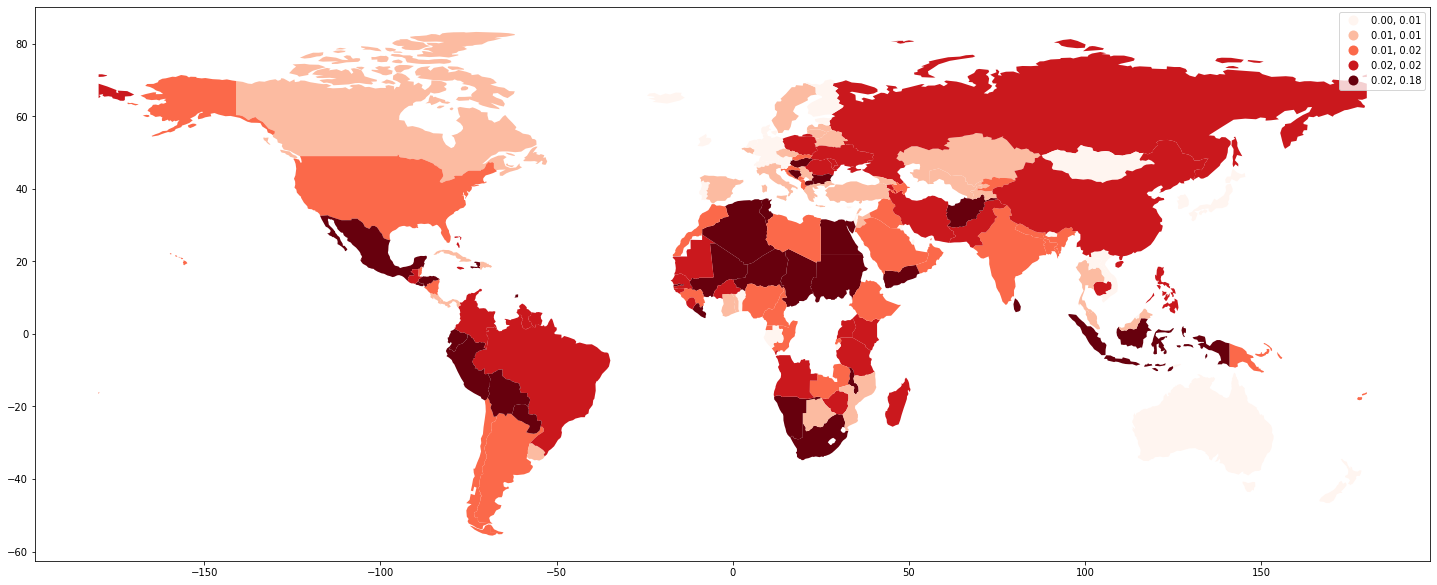

In [244]:
# plot confirmed cases world map 
merge.plot(column='Deaths/Cases', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='Reds')
# add countries names and numbers 

plt.show()

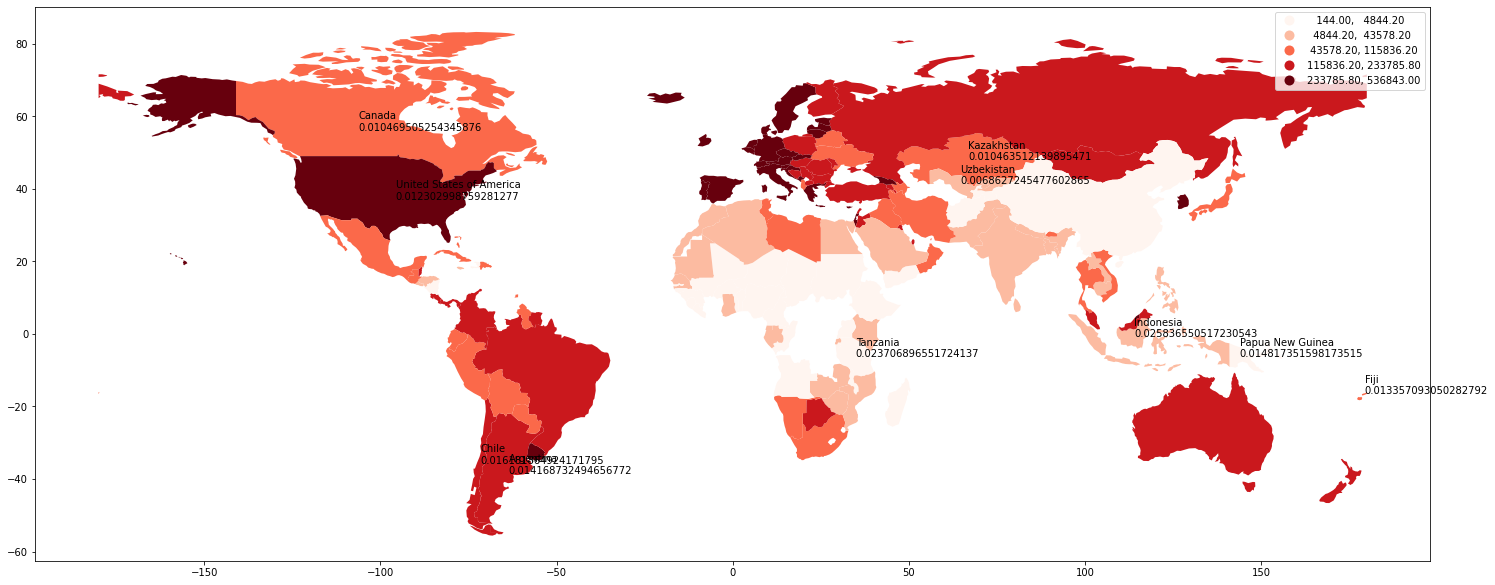

In [245]:
# plot confirmed cases world map 
merge.plot(column='Tot\xa0Cases/1M pop', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='Reds')
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge['Deaths/Cases'][i]),size=10)
plt.show()

<AxesSubplot:xlabel='Tot\xa0Cases/1M pop', ylabel='Deaths/Cases'>

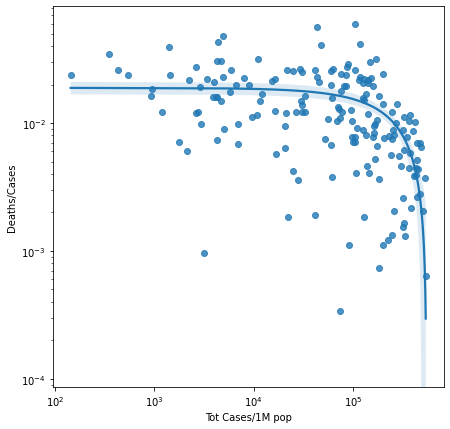

In [274]:
df_1 = copy.deepcopy(df)
df_1 = df_1.drop(df_1['Deaths/Cases'].idxmax())
df_1 = df_1.drop(df_1['Deaths/Cases'].idxmax())

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="symlog",yscale='log')

sns.regplot(x='Tot\xa0Cases/1M pop', y='Deaths/Cases', data=df_1,ax = ax)

<AxesSubplot:xlabel='GDP (nominal, 2017)', ylabel='Deaths/Cases'>

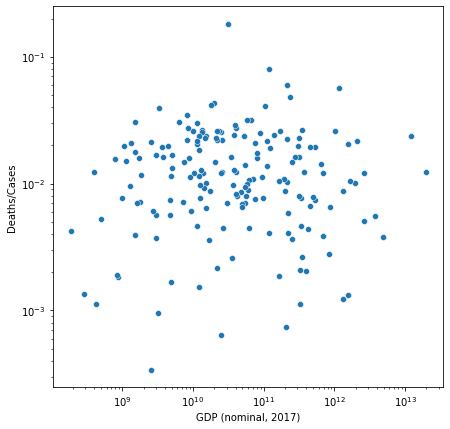

In [299]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log",yscale='log')
sns.scatterplot(x='GDP (nominal, 2017)', y='Deaths/Cases', data=df,ax = ax)

In [249]:
Y = stats.zscore(df['Deaths/Cases'])
X = stats.zscore(df['Tot\xa0Cases/1M pop'])
model_OLS = sm.OLS(Y,X)
result_OLS = model_OLS.fit()
result_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Deaths/Cases   R-squared (uncentered):                   0.124
Model:                            OLS   Adj. R-squared (uncentered):              0.119
Method:                 Least Squares   F-statistic:                              25.14
Date:                Tue, 03 May 2022   Prob (F-statistic):                    1.29e-06
Time:                        13:18:31   Log-Likelihood:                         -240.75
No. Observations:                 178   AIC:                                      483.5
Df Residuals:                     177   BIC:                                      486.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Tot Cases/1M pop    -0.3527      0.070     -5.014      0.000      -0.491      -0.214
==============================================================================
Omnibus:                      255.541   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23961.595
Skew:                           6.102   Prob(JB):                         0.00
Kurtosis:                      58.514   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [250]:
Y_pred = result_OLS.predict(X)

In [251]:
_std = np.sqrt((Y-Y_pred)**2)
_std

0      0.100855
1      0.138657
2      0.861019
3      0.187811
4      0.450053
         ...   
174    0.515194
175    0.943564
176    0.455415
178    0.544457
180    0.927586
Length: 178, dtype: float64

<AxesSubplot:xlabel='Tot\xa0Cases/1M pop'>

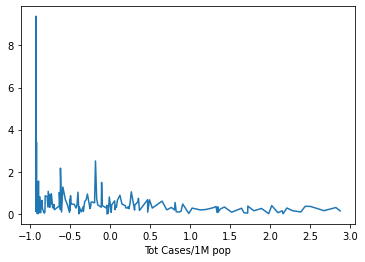

In [252]:
sns.lineplot(x = X,y = _std)

In [294]:
from sklearn.cluster import KMeans
X = merge[["Deaths/Cases","TotalCases"]]
kmeans = KMeans(n_clusters=7).fit(X)
merge['label'] = kmeans.labels_

In [292]:
df.columns

Index(['GDP (nominal, 2017)', 'GDP per capita', 'Country', 'CODE', '#',
       'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered',
       'NewRecovered', 'ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop',
       'Deaths/1M pop', 'TotalTests', 'Tests/ 1M pop', 'Population',
       'Continent', '1 Caseevery X ppl', '1 Deathevery X ppl',
       '1 Testevery X ppl', 'New Cases/1M pop', 'New Deaths/1M pop',
       'Active Cases/1M pop', 'Deaths/Cases'],
      dtype='object')

/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/mapclassify/classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/home/duy/anaconda3/envs/dv_lab01/lib/python3.7/site-packages/mapclassify/classifiers.py:241: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


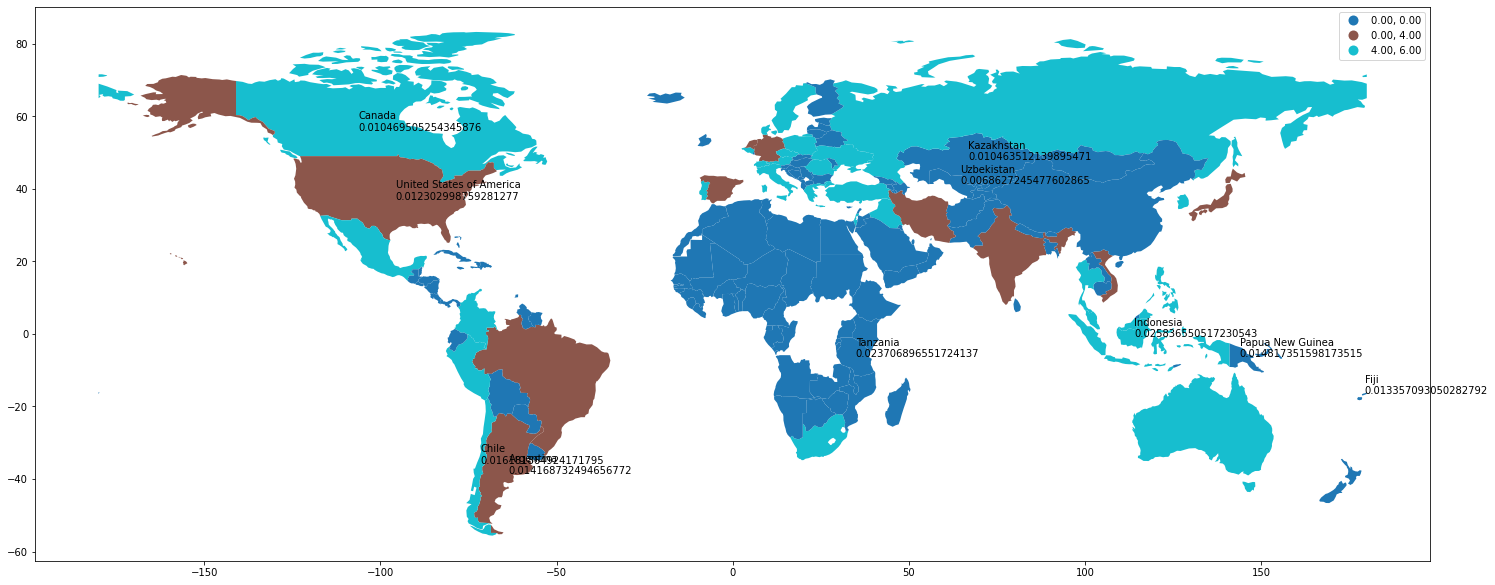

In [296]:
# plot confirmed cases world map 
merge.plot(column='label', scheme="quantiles",
           figsize=(25, 20),
           legend=True,cmap='tab10')
# add countries names and numbers 
for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge['Deaths/Cases'][i]),size=10)
plt.show()

<AxesSubplot:xlabel='GDP (nominal, 2017)', ylabel='Deaths/Cases'>

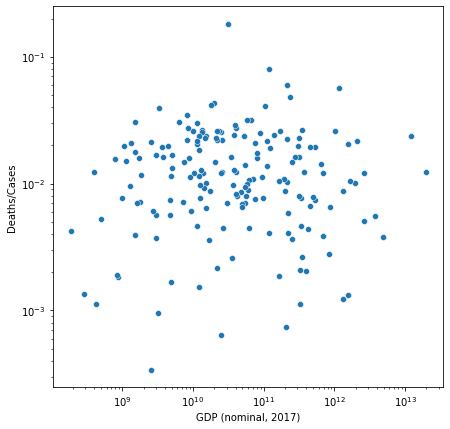

In [298]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='GDP (nominal, 2017)', y='Deaths/Cases', data=df,ax = ax)